# Import all packages

In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets

from torchinfo import summary



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
 torch.cuda.is_available()

False

# Angular Spectrum

In [4]:
def angular_spectrum_propagation(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 4D torch tensor (batch, channel, x, y)
        wvl     : float (wavelength of light in meters)
        dx      : float (sampling interval in meters)
        z       : float (propagation distance in meters)

    Returns:
        U1  : the propagated field (same shape as U0)
    """
    batch, channel, original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2

    z = torch.tensor([z], device=U0.device)
    # Pad input field
    U0_padded = torch.zeros((batch, channel, original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype, device=U0.device)
    U0_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0

    ny, nx = U0_padded.shape[-2:]
    k = 2 * torch.pi / wvl

    # Create spatial frequency coordinates
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)
    fy = torch.fft.fftfreq(ny, dx, device=U0.device)
    FX, FY = torch.meshgrid(fx, fy)  # Ensure FX and FY have last two dimensions
    FX = FX.reshape(1,1, FX.shape[0], FX.shape[1])
    FY = FY.reshape(1,1, FY.shape[0], FY.shape[1])

    Delta_uy = 1 / (ny * dx)
    Delta_ux = 1 / (nx * dx)
    u_limity = 1 / (torch.sqrt((2 * Delta_uy * z) ** 2 + 1) * wvl)
    u_limitx = 1 / (torch.sqrt((2 * Delta_ux * z) ** 2 + 1) * wvl)
    H_limit = ((FY ** 2 / u_limity ** 2 + FX ** 2 * wvl ** 2) < 1) * ((FX ** 2 / u_limitx ** 2 + FY ** 2 * wvl ** 2) < 1)

    # Kernel
    H = torch.exp(1j * k * z * torch.sqrt(1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # Propagate
    U1_padded = torch.fft.fftshift(torch.fft.ifft2(torch.fft.fft2(torch.fft.ifftshift(U0_padded, dim=(-2, -1))) * H * H_limit), dim=(-2, -1))

    # Extract to initial size
    U1 = U1_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width]

    return U1

# Load pretrained model and define U-Net architecture
This model was trained on 3s and 7s with the same defocus distance.

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # BatchNorm after Conv2d
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # BatchNorm after Conv2d
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # BatchNorm after Conv2d
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # BatchNorm after Conv2d
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # BatchNorm after Conv2d
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),  # BatchNorm after Conv2d
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

model = torch.load('U-net_defocus.pt', weights_only=False, map_location=torch.device(device))
model.eval()  # Switch to evaluation mode (important for inference)
model.to(device)

UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')


In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       73,856
│    └─BatchNorm2d: 2-5                  256
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-8                       295,168
│    └─BatchNorm2d: 2-9                  512
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      295,040
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
├─Sequential: 1-3                        --
│    └─Upsample: 2-14                    --
│    └─Conv2d: 2-15                      73,792
│    └─BatchNorm2d: 2-16                 128
│    └─ReLU: 2-17                        --
│  

# Evaluate Model
We can evaluate the model but be sure it's normalized to [0,1]. So peak intensity should be 1.

In [8]:
def evaluate(model, img):
    """
    Evaluate a single `image` with torch array size (28, 28).
    Returns the model output as a single torch array with `(28, 28)`
    """
    output = model(img.reshape(1,1,28, 28)).reshape(28, 28)

    return output

def plot_images(inputs, outputs, targets):
    # Create a figure with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plot input image
    ax[0].imshow(inputs.reshape(28, 28).detach().cpu().numpy())
    ax[0].set_title("Input Image")
    ax[0].axis('off')

    # Plot output image
    ax[1].imshow(outputs.reshape(28, 28).detach().cpu().numpy())
    ax[1].set_title("Network Output Image")
    ax[1].axis('off')

    # Plot target image
    ax[2].imshow(targets.reshape(28, 28).detach().cpu().numpy())
    ax[2].set_title("Target Image")
    ax[2].axis('off')

    plt.show()

# Load dataset and prepare
Dataset is a tensor where the first dimension is the different images.

In [9]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset5s = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

only_number = 5
dataset5s.data = dataset5s.data[(dataset5s.targets == only_number)]
dataset5s.targets = dataset5s.targets[(dataset5s.targets == only_number)]



dataset3s = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

only_number = 3
dataset3s.data = dataset3s.data[(dataset3s.targets == only_number)]
dataset3s.targets = dataset3s.targets[(dataset3s.targets == only_number)]

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.26MB/s]


<ipython-input-10-d8ee1579dd96>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(dataset5s.data[index], dtype=torch.float, device=device) / 255
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


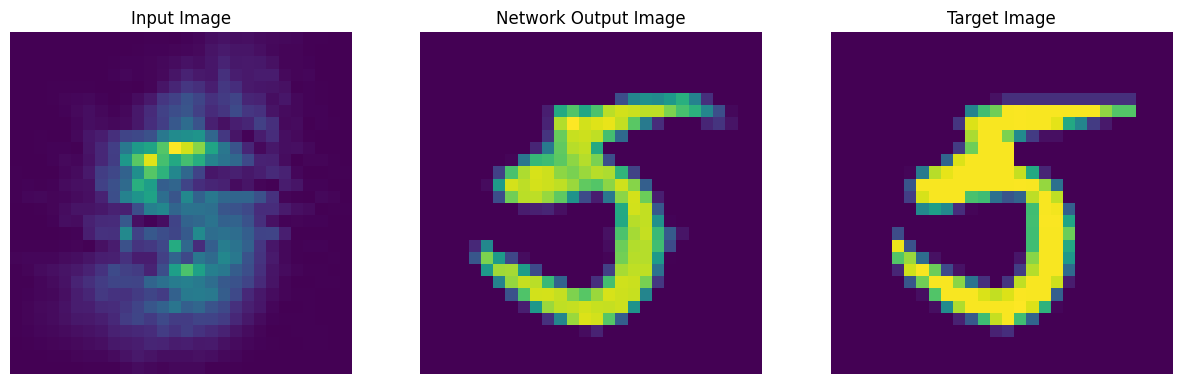

In [10]:
index = 500

image = torch.tensor(dataset5s.data[index], dtype=torch.float, device=device) / 255

image_prop = torch.abs(angular_spectrum_propagation(image.reshape(1,1,28,28),633e-9, 3e-6, 300e-6))**2
output = evaluate(model, image_prop)


plot_images(image_prop, output, image)

# Task
Test the network's ability to defocus different distances. The network was trained with the following parameters: `torch.abs(angular_spectrum_propagation(image.reshape(1,1,28,28),633e-9, 3e-6, 300e-6))**2`.
To do this task do the following:

- Provide some visual examples for the output of the network for images which have been defocused at different distances.
- Evaluate the SSIM performance for different defocusing distances. Use the mean of the SSIM of many images of 3s in order to evaluate the performance.
- Evaluate the SSIM performance for different defocusing distances. Use the mean of the SSIM of many images of 5s in order to evaluate the performance.

In [14]:

!pip install torchmetrics
from torchmetrics.image import StructuralSimilarityIndexMeasure

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [16]:
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

<ipython-input-42-c2380f24b9e8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(dataset3s.data[index], dtype=torch.float, device=device) / 255


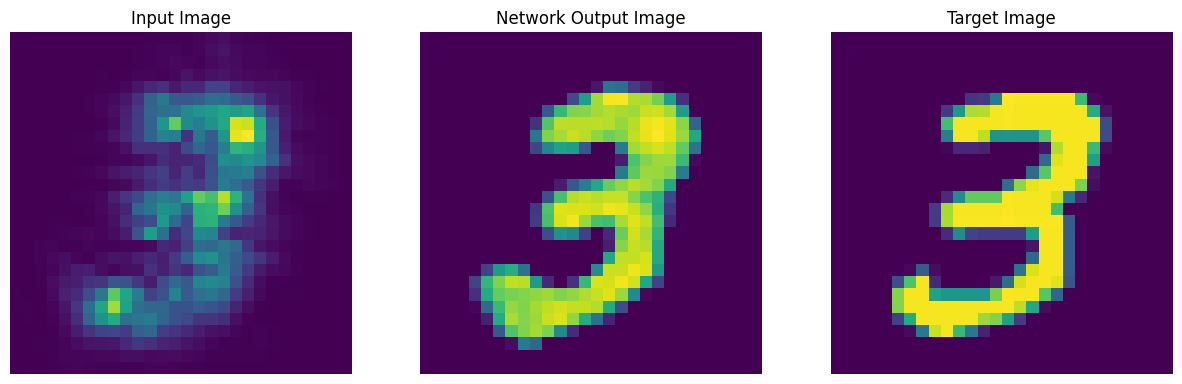

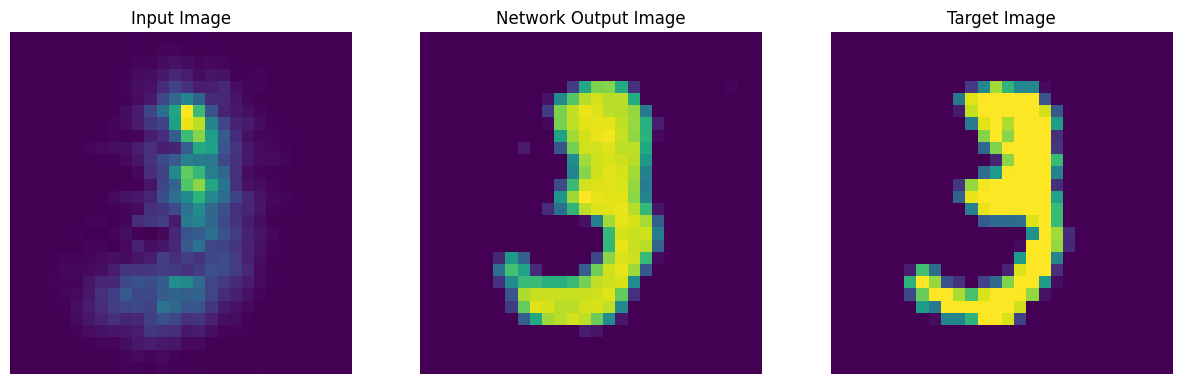

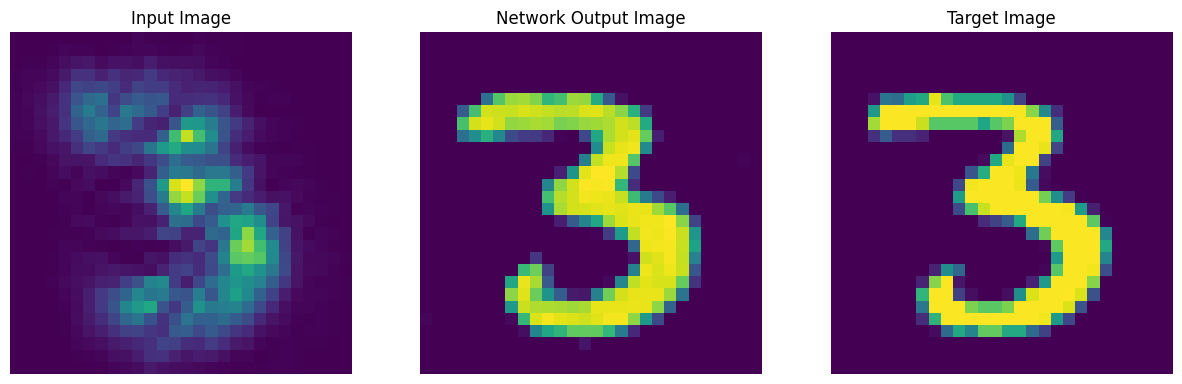

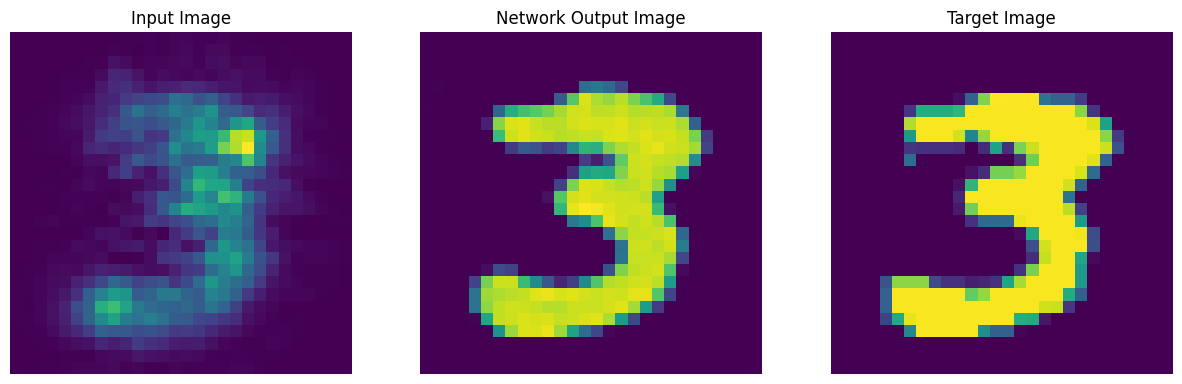

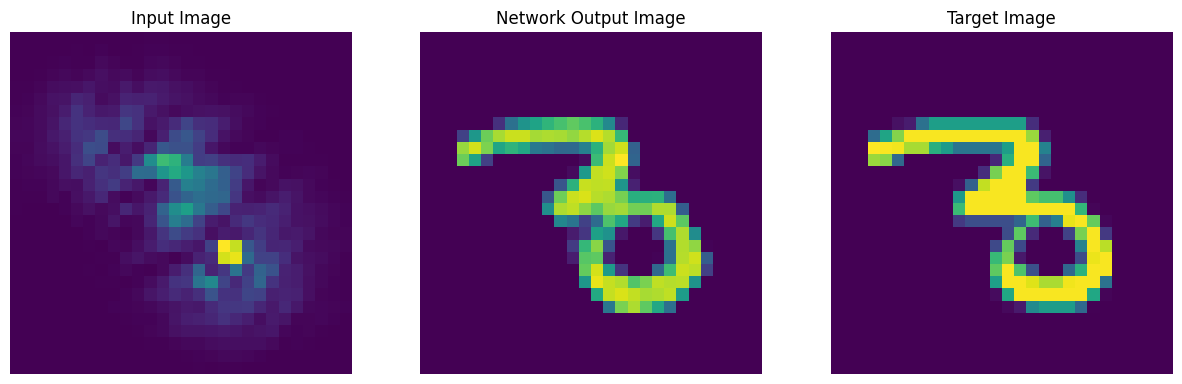

<ipython-input-42-c2380f24b9e8>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(dataset5s.data[index], dtype=torch.float, device=device) / 255


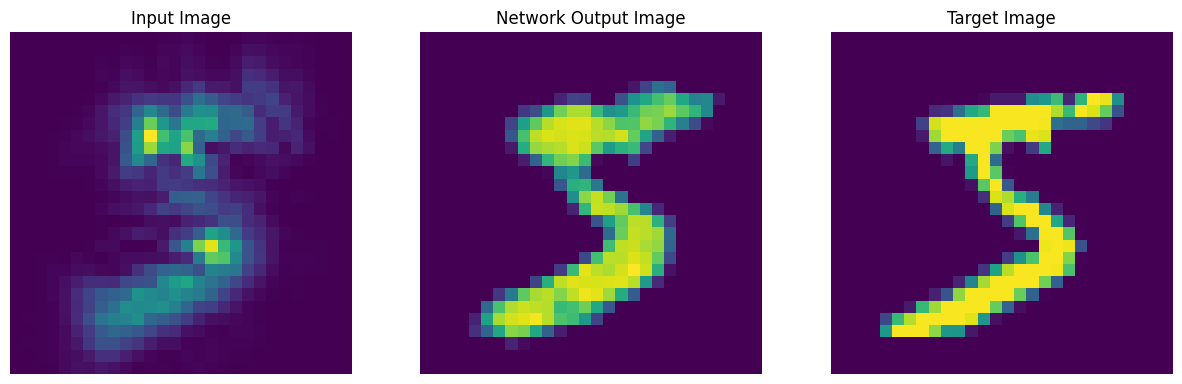

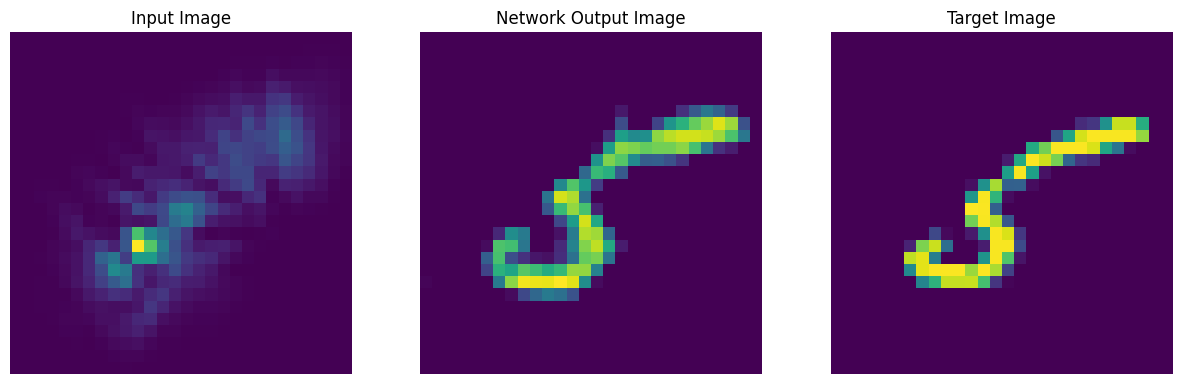

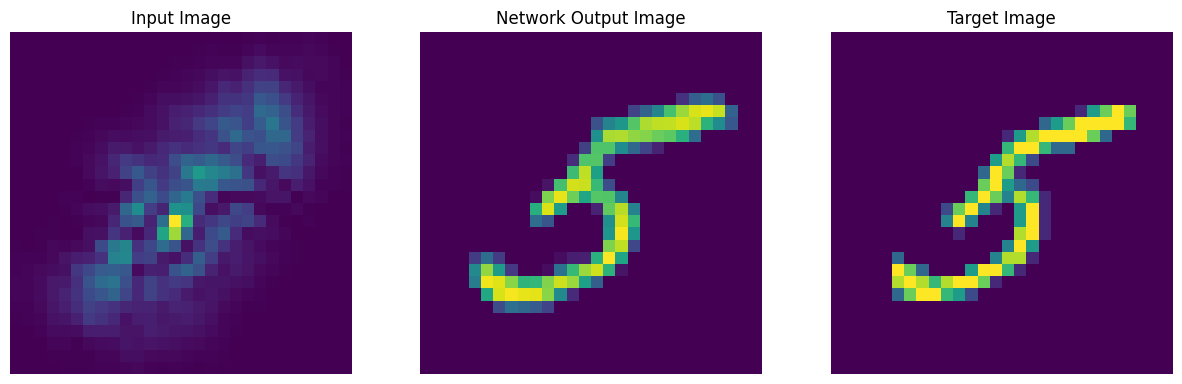

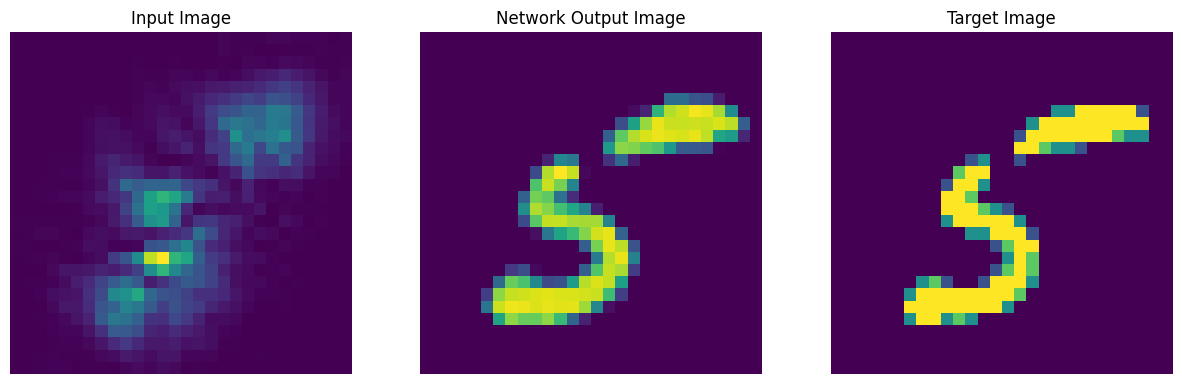

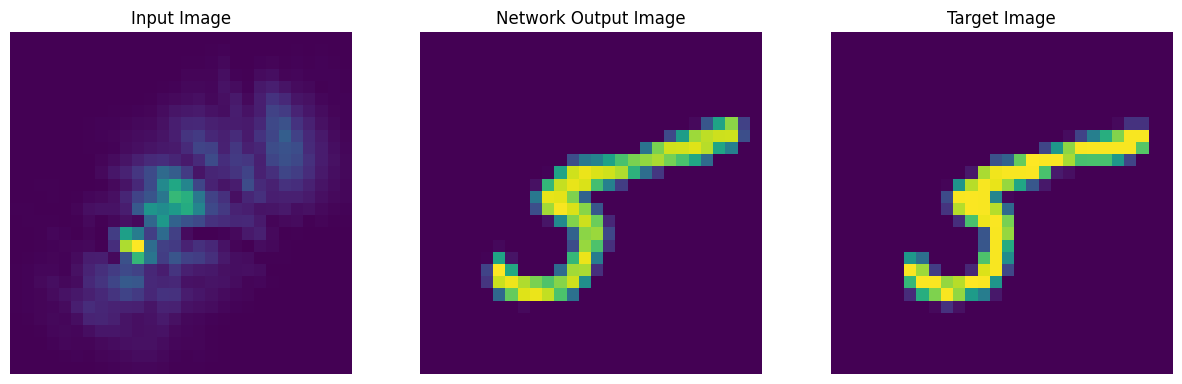

In [42]:


for index in range(5):
    prop_distance = 200e-6 + 20*index*1e-6
    image = torch.tensor(dataset3s.data[index], dtype=torch.float, device=device) / 255

    image_prop = torch.abs(angular_spectrum_propagation(image.reshape(1,1,28,28),633e-9, 3e-6, prop_distance))**2
    output = evaluate(model, image_prop)
    plot_images(image_prop, output, image)




for index in range(5):
    prop_distance = 200e-6 + 20*index*1e-6
    image = torch.tensor(dataset5s.data[index], dtype=torch.float, device=device) / 255

    image_prop = torch.abs(angular_spectrum_propagation(image.reshape(1,1,28,28),633e-9, 3e-6, prop_distance))**2
    output = evaluate(model, image_prop)
    plot_images(image_prop, output, image)

In [51]:
ssim_means3 = []
distances3 = []

# Loop over different defocus distances
for i in range(40):

    dist = 200e-6 + i*10*1e-6
    distances3.append(dist)

    res_ssim = []
    for index in range(40):  # Loop over a subset of images
        image = torch.tensor(dataset3s.data[index], dtype=torch.float, device=device) / 255
        image_prop = torch.abs(angular_spectrum_propagation(image.reshape(1,1,28,28),633e-9, 3e-6, dist))**2

        output = evaluate(model, image_prop)

        s3 = ssim(image.reshape(1,1,28,28), output.reshape(1,1,28,28)).item()
        res_ssim.append(s3)

    ssim_means3.append(np.mean(res_ssim))

<ipython-input-51-e3eb5ff1e38b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(dataset3s.data[index], dtype=torch.float, device=device) / 255


Max SSIM: 0.9855 at 3.00e-04 µm


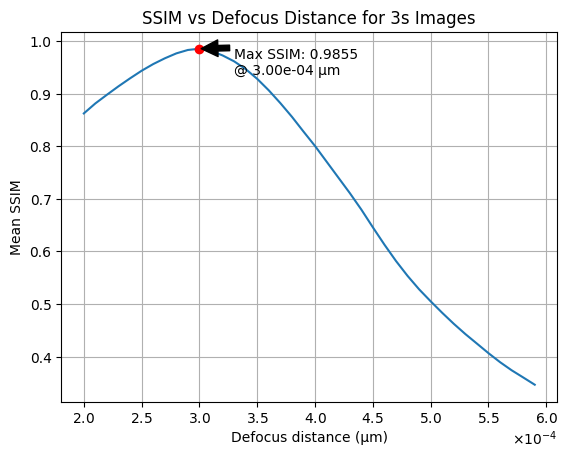

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Find max value and corresponding defocus distance
max_ssim = max(ssim_means3)
max_index = ssim_means3.index(max_ssim)
max_distance = distances3[max_index]
print(f"Max SSIM: {max_ssim:.4f} at {max_distance:.2e} µm")

# Plot
plt.plot(distances3, ssim_means3)
plt.xlabel("Defocus distance (µm)")
plt.ylabel("Mean SSIM")
plt.title("SSIM vs Defocus Distance for 3s Images")
plt.grid(True)

# Format x-axis with scientific notation
ax = plt.gca()
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))
ax.xaxis.set_major_formatter(formatter)

# Annotate the max point
plt.plot(max_distance, max_ssim, 'ro')  # red dot
plt.annotate(
    f'Max SSIM: {max_ssim:.4f}\n@ {max_distance:.2e} µm',
    xy=(max_distance, max_ssim),
    xytext=(max_distance * 1.1, max_ssim - 0.05),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=10
)

plt.show()


In [53]:
ssim_means5 = []
distances5 = []

# Loop over different defocus distances
for i in range(40):

    dist = 200e-6 + i*10*1e-6
    distances5.append(dist)

    res_ssim = []
    for index in range(40):  # Loop over a subset of images
        image = torch.tensor(dataset5s.data[index], dtype=torch.float, device=device) / 255
        image_prop = torch.abs(angular_spectrum_propagation(image.reshape(1,1,28,28),633e-9, 3e-6, dist))**2

        output = evaluate(model, image_prop)

        s5 = ssim(image.reshape(1,1,28,28), output.reshape(1,1,28,28)).item()
        res_ssim.append(s5)

    ssim_means5.append(np.mean(res_ssim))

<ipython-input-53-1e612bc42fcb>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(dataset5s.data[index], dtype=torch.float, device=device) / 255


Max SSIM: 0.9368 at 2.90e-04 µm


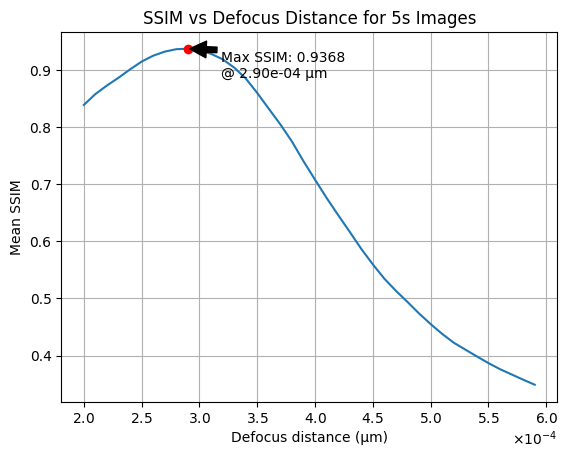

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Find max value and corresponding defocus distance
max_ssim = max(ssim_means5)
max_index = ssim_means5.index(max_ssim)
max_distance = distances5[max_index]
print(f"Max SSIM: {max_ssim:.4f} at {max_distance:.2e} µm")

# Plot
plt.plot(distances5, ssim_means5)
plt.xlabel("Defocus distance (µm)")
plt.ylabel("Mean SSIM")
plt.title("SSIM vs Defocus Distance for 5s Images")
plt.grid(True)

# Format x-axis with scientific notation
ax = plt.gca()
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))
ax.xaxis.set_major_formatter(formatter)

# Annotate the max point
plt.plot(max_distance, max_ssim, 'ro')  # red dot
plt.annotate(
    f'Max SSIM: {max_ssim:.4f}\n@ {max_distance:.2e} µm',
    xy=(max_distance, max_ssim),
    xytext=(max_distance * 1.1, max_ssim - 0.05),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=10
)

plt.show()


In the 3s case, the maximum mean SSIM is reached @ 300e-6 m which was expected since the model was trained at this defocus distance.
However, in the 5s case, the maximum value is not reached at the training distance but at 290e-6 m. The stepsize was 10um so a thinner size would lead to better precision.


